In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 319 (delta 110), reused 104 (delta 83), pack-reused 164
Receiving objects: 100% (319/319), 232.35 KiB | 9.29 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [3]:
cd lag-llama

/content/lag-llama


In [4]:
!pip3 install -r requirements.txt --quiet
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 64.4 MB/s eta 0:00:00
ERROR: pip's dependency resol

In [64]:
from itertools import islice
from tqdm.autonotebook import tqdm

import torch

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.common import ListDataset

import pandas as pd
import numpy as np

from lag_llama.gluon.estimator import LagLlamaEstimator

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns

from sklearn.metrics import mean_absolute_error

In [6]:
# Read data
# ==============================================================================
data_dir = '/content/drive/MyDrive/Python Scripts/Lag Llama experiments/Data'

df = pd.read_csv(data_dir + '/spain_clean.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')
df.drop(columns = ['period'], inplace = True)

# Aggregate data to daily frequency - highest observed wave
# ==============================================================================
df = (
    df
    .resample(rule="D", closed="left", label="right")
    .agg({"wave_height": "max"})
)

# Train-test split
# ==============================================================================
one_month = (-1)*30 # One month
two_months = (-1)*60 # Two months

end_val = two_months + one_month
end_train = end_val + two_months + one_month

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-19 00:00:00 --- 2023-12-22 00:00:00  (n=1282)
Validation dates : 2023-12-23 00:00:00 --- 2024-03-21 00:00:00  (n=90)
Test dates       : 2024-03-22 00:00:00 --- 2024-06-19 00:00:00  (n=90)


In [9]:
def create_gluonts_dataset(df, freq, target_column):
    series = {
        "start": df.index[0],  # start date of the time series
        "target": df[target_column].values,  # target values
    }

    dataset = ListDataset([series], freq=freq)
    return dataset

# Create the GluonTS dataset
train = create_gluonts_dataset(df_train, freq='D', target_column='wave_height')
test = create_gluonts_dataset(df_test, freq='D', target_column='wave_height')
val = create_gluonts_dataset(df_val, freq='D', target_column='wave_height')

print('Train dataset:', train)
print('Validation dataset:',val)
print('Test dataset:',test)

Train dataset: [{'start': Period('2020-06-19', 'D'), 'target': array([0.87, 0.9 , 0.7 , ..., 1.08, 2.11, 3.07], dtype=float32)}]
Validation dataset: [{'start': Period('2023-12-23', 'D'), 'target': array([3.4 , 2.99, 1.76, 1.36, 1.4 , 1.14, 1.84, 1.64, 1.18, 3.26, 2.81,
       1.54, 2.77, 2.45, 1.85, 2.2 , 1.59, 1.26, 1.59, 1.64, 1.42, 1.44,
       1.18, 0.58, 0.53, 0.78, 1.14, 2.05, 2.32, 1.47, 1.35, 2.56, 2.11,
       2.16, 1.84, 1.37, 1.89, 1.87, 1.33, 1.84, 1.7 , 1.13, 1.81, 1.55,
       1.79, 1.79, 1.39, 1.05, 1.25, 1.13, 3.99, 3.97, 3.43, 1.39, 1.31,
       1.36, 1.26, 1.28, 1.23, 1.18, 1.48, 2.21, 4.24, 4.27, 4.42, 3.89,
       5.36, 4.54, 2.21, 3.42, 3.47, 3.53, 2.38, 2.44, 2.33, 2.13, 1.5 ,
       1.8 , 1.67, 3.47, 2.45, 1.46, 1.18, 0.81, 0.73, 0.73, 0.74, 0.96,
       1.17, 1.1 ], dtype=float32)}]
Test dataset: [{'start': Period('2024-03-22', 'D'), 'target': array([1.24, 1.6 , 1.87, 2.27, 2.09, 2.18, 3.25, 3.19, 2.44, 1.59, 1.28,
       1.94, 1.64, 0.8 , 1.1 , 1.23, 1.1 , 1.13

We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [8]:
def get_lag_llama_predictions(dataset,
                                model_ckpt,
                                prediction_length = 24,
                                context_length=None,
                                num_samples=100,
                                device="cpu",
                                batch_size=64,
                                nonnegative_pred_samples=True):


    _device = torch.device(device)
    _ckpt = torch.load(model_ckpt, map_location=_device)
    estimator_args = _ckpt["hyper_parameters"]["model_kwargs"]
    if context_length == None:
      context_length=estimator_args['context_length']

    estimator = LagLlamaEstimator(
        # ckpt_path="lag-llama.ckpt",
        ckpt_path = model_ckpt,
        context_length=context_length,
        prediction_length=prediction_length,
        device = _device,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        nonnegative_pred_samples=nonnegative_pred_samples,

        # linear positional encoding scaling
        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=batch_size,
        num_parallel_samples=num_samples,
    )

    lightning_module = estimator.create_lightning_module().to(device)
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(tqdm(forecast_it, total=len(dataset[0]['target']), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset[0]['target']), desc="Ground truth"))

    return forecasts, tss

In [51]:
# def recursive_forecast(
#     model_ckpt,
#     context_df,
#     test_df,
#     prediction_length = 24,
#     context_length = None,
#     device = 'cuda',
#     num_samples = 100):

#     context_gdf = create_gluonts_dataset(context_df, freq='D', target_column='wave_height')
#     _device = torch.device(device)
#     _ckpt = torch.load(model_ckpt, map_location=_device)
#     estimator_args = _ckpt["hyper_parameters"]["model_kwargs"]

#     batch_size = prediction_length  # Number of observations to add to context at each step of the forecast. Same as prediction length.
#     total_length = len(df_test)  # Total length of the target DataFrame
#     if context_length == None:
#       context_length=estimator_args['context_length']

#     all_point_forecasts = []
#     q10_forecasts = []
#     q90_forecasts = []

#     # Append batches sequentially to the target DataFrame
#     for i in range(0, total_length, batch_size):

#         # Prediction based on context dataset
#         forecasts, tss = get_lag_llama_predictions(
#         model_ckpt = model_ckpt,
#         dataset = context_gdf,
#         prediction_length=prediction_length,
#         num_samples=num_samples,
#         context_length=context_length,
#         device=_device
#         )

#         point_forecast = list(forecasts[0].mean)
#         q10 = list(forecasts[0]['p10'])
#         q90 = list(forecasts[0]['p90'])

#         # Append the point forecast to the target list
#         all_point_forecasts.extend(point_forecast)
#         q10_forecasts.extend(q10)
#         q90_forecasts.extend(q90)

#         # Update context dataset
#         batch_start_index = i
#         batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of target_df
#         batch = test_df.iloc[batch_start_index:batch_end_index]
#         context_df = pd.concat([context_df, batch], ignore_index=False)
#         context_gdf = create_gluonts_dataset(context_df, freq='D', target_column='wave_height')

#     test_n_preds_df = {}
#     test_n_preds_df['prediction'] = all_point_forecasts
#     test_n_preds_df['p10'] = q10_forecasts
#     test_n_preds_df['p90'] = q90_forecasts

#     return test_n_preds_df


def recursive_forecast(
    model_ckpt,
    context_df,
    test_df,
    prediction_length=7,
    context_length=None,
    device='cuda',
    num_samples=100):

    context_gdf = create_gluonts_dataset(context_df, freq='D', target_column='wave_height')
    _device = torch.device(device)
    _ckpt = torch.load(model_ckpt, map_location=_device)
    estimator_args = _ckpt["hyper_parameters"]["model_kwargs"]

    batch_size = prediction_length  # Number of observations to add to context at each step of the forecast.
    total_length = len(test_df)  # Total length of the target DataFrame
    if context_length is None:
        context_length = estimator_args['context_length']

    all_point_forecasts = []
    q10_forecasts = []
    q90_forecasts = []

    # Append batches sequentially to the target DataFrame
    for i in range(0, total_length, batch_size):
        # Prediction based on context dataset
        forecasts, tss = get_lag_llama_predictions(
            model_ckpt=model_ckpt,
            dataset=context_gdf,
            prediction_length=prediction_length,
            num_samples=num_samples,
            context_length=context_length,
            device=_device
        )

        point_forecast = list(forecasts[0].mean)
        q10 = list(forecasts[0]['p10'])
        q90 = list(forecasts[0]['p90'])

        # Ensure to append only 7 predictions each iteration
        all_point_forecasts.extend(point_forecast[:batch_size])
        q10_forecasts.extend(q10[:batch_size])
        q90_forecasts.extend(q90[:batch_size])

        # Update context dataset
        batch_start_index = i
        batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of test_df
        batch = test_df.iloc[batch_start_index:batch_end_index]
        context_df = pd.concat([context_df, batch], ignore_index=False)
        context_gdf = create_gluonts_dataset(context_df, freq='D', target_column='wave_height')

    # Ensure final lengths match total_length
    test_n_preds_df = {
        'prediction': all_point_forecasts[:total_length],
        'p10': q10_forecasts[:total_length],
        'p90': q90_forecasts[:total_length]
    }

    return test_n_preds_df


In [37]:
def plot_preds(model_dir, title):
  forecasts, tss = get_lag_llama_predictions(
      test,
      model_ckpt = model_dir,
      prediction_length=24,
      num_samples=num_samples,
      # context_length=context_length,
      device=torch.device('cuda')
    )

  plt.figure(figsize=(20, 15))
  date_formater = mdates.DateFormatter('%b, %d')
  plt.rcParams.update({'font.size': 15})

  for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
      ax = plt.subplot(3, 3, idx+1)

      plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
      forecast.plot( color='g')
      plt.xticks(rotation=60)
      ax.xaxis.set_major_formatter(date_formater)
      ax.set_title(forecast.item_id)

  plt.gcf().tight_layout()
  plt.title(title)
  plt.legend()
  plt.show()

In [38]:
def plot_backtest_preds(df_actual_pred, actual_col, pred_col):
    fig = go.Figure()
    trace1 = go.Scatter(x=df_actual_pred.index, y=df_actual_pred[actual_col], name="actual", mode="lines")
    trace2 = go.Scatter(x=df_actual_pred.index, y=df_actual_pred[pred_col], name="prediction", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Actual value vs predicted in test data",
        xaxis_title="Date time",
        yaxis_title="Wave height (meters)",
        width=800,
        height=400,
        margin=dict(l=20, r=20, t=35, b=20),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.001
        )
    )

    fig.show()

In [79]:
def plot_prob_forecasts(df_forecasts):
    """
    Plots real values and predicted values with confidence intervals.

    Parameters:
    df_forecasts (pd.DataFrame): DataFrame containing the real values, predicted values,
                                 and confidence intervals with columns ['wave_height', 'p10', 'p90'].
    """
    # Plot shaded area
    fig = go.Figure([
        go.Scatter(name='Real value', x=df_forecasts.index, y=df_forecasts['wave_height'], mode='lines'),
        go.Scatter(name='Point forecast', x=df_forecasts.index, y=df_forecasts['prediction'], mode='lines'),
        go.Scatter(
            name='Upper Bound', x=df_forecasts.index, y=df_forecasts['p90'],
            mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Lower Bound', x=df_forecasts.index, y=df_forecasts['p10'],
            marker=dict(color="#444"), line=dict(width=0), mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
        )
    ])
    fig.update_layout(
        title="Real value vs predicted in test data",
        xaxis_title="Date",
        yaxis_title="Wave height (Meters)",
        width=900,
        height=400,
        margin=dict(l=20, r=20, t=35, b=20),
        hovermode="x",
        legend=dict(
            orientation="h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.001
        )
    )
    fig.show()

In [65]:
def empirical_coverage(y, lower_bound, upper_bound):
    """
    Calculate coverage of a given interval
    """
    return np.mean(np.logical_and(y >= lower_bound, y <= upper_bound))

## Zero-shot forecasting

In [39]:
# Forecast parameters
checkpoint = 'lag-llama/lag-llama.ckpt'
prediction_length = 24
# context_length = 32
num_samples = 100
device = torch.device('cuda')

In [40]:
forecasts, tss = get_lag_llama_predictions(
    test,
    model_ckpt = checkpoint,
    prediction_length=prediction_length,
    num_samples=num_samples,
    # context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/90 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/90 [00:00<?, ?it/s]

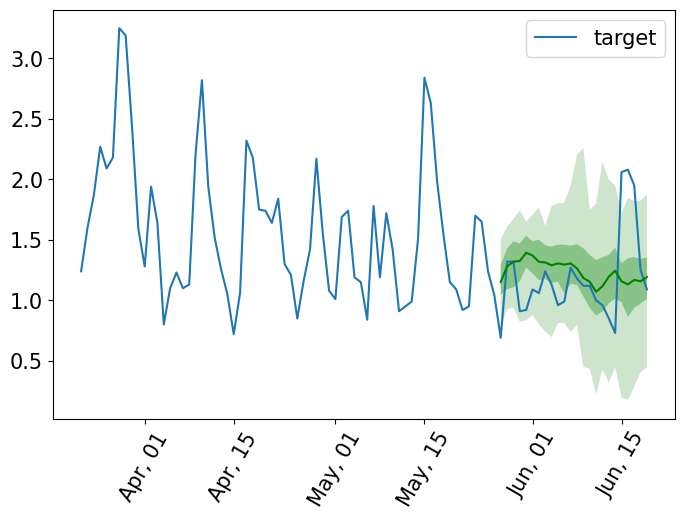

In [41]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [86]:
forecasts_dict = recursive_forecast(model_ckpt = checkpoint, context_df=df_train[-48:], test_df = df_test, prediction_length=7)

Forecasting batches:   0%|          | 0/48 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/48 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/55 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/55 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/62 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/62 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/69 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/69 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/76 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/76 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/83 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/83 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/90 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/90 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/97 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/97 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/111 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/111 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/118 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/118 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/125 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/125 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/132 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/132 [00:00<?, ?it/s]

In [87]:
assert len(forecasts_dict['prediction']) == len(df_test)
assert len(forecasts_dict['p10']) == len(df_test)
assert len(forecasts_dict['p90']) == len(df_test)

In [88]:
df_forecasts = df_test.copy()
df_forecasts['prediction'] = forecasts_dict['prediction']
df_forecasts['p10'] = forecasts_dict['p10']
df_forecasts['p90'] = forecasts_dict['p90']

In [89]:
plot_backtest_preds(df_forecasts, 'wave_height', 'prediction')

In [90]:
plot_prob_forecasts(df_forecasts)


In [91]:
metric = mean_absolute_error(df_forecasts['wave_height'], df_forecasts['prediction'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.649597505595949


In [92]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
    y = df_forecasts['wave_height'],
    lower_bound = df_forecasts['p10'],
    upper_bound = df_forecasts['p90']
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (df_forecasts['p90'] - df_forecasts['p10']).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 74.44 %
Area of the interval: 157.83999633789062


# Forecasting with fine-tuned models - Hourly data



## RoPE models


In [ ]:
ckpt_dir = '/content/drive/MyDrive/Python Scripts/Lag Llama experiments/lightning_logs/RoPE models'

cl16 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'
cl32 = ckpt_dir + '/cl32_lr10e3/checkpoints/epoch=41-step=2100.ckpt'
cl64 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'

# checkpoints = [cl16, cl32, cl64]

### Model with cl = 16


In [ ]:
# Produce forecasts
df_forecasts_16 = recursive_forecast(model_ckpt = cl16, context_df=df_train[-16:], test_df = df_test)

Forecasting batches:   0%|          | 0/16 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/16 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/40 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/40 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/64 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/64 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/88 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/88 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/544 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/568 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/568 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/592 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/592 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/616 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/616 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/640 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/640 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/664 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/664 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/688 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/688 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/712 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/712 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/736 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/736 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/760 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/760 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/784 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/784 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/808 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/808 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/832 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/832 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/856 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/856 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/880 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/880 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/904 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/904 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/928 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/928 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/952 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/952 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/976 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/976 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1000 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1024 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1048 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1048 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1072 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1072 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1096 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1432 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_16, 'wave_height', 'forecasts')

In [ ]:
# Evaluation
metric = mean_absolute_error(df_forecasts_16['wave_height'], df_forecasts_16['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.6956580517483462


### Model with cl = 32


In [ ]:
# Produce forecasts
df_forecasts_32 = recursive_forecast(model_ckpt = cl32, context_df=df_train[-32:], test_df = df_test)

Forecasting batches:   0%|          | 0/32 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/32 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/56 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/56 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/80 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/80 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/128 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/128 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/152 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/152 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/176 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/176 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/200 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/200 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/224 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/224 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/248 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/248 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/272 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/272 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/296 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/296 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/320 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/320 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/344 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/344 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/368 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/368 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/392 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/392 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/416 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/416 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/440 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/464 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/464 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/488 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/488 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/536 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/536 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/560 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/560 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/584 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/584 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/608 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/608 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/632 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/632 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/656 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/656 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/680 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/680 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/704 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/704 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/728 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/728 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/752 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/752 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/776 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/776 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/800 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/800 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/824 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/824 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/848 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/848 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/872 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/872 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/896 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/896 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/920 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/920 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/944 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/944 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/968 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/968 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/992 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/992 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1016 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1016 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1040 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1040 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1064 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1064 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1088 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1088 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1448 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_32, 'wave_height', 'forecasts')

# Evaluation
metric = mean_absolute_error(df_forecasts_32['wave_height'], df_forecasts_32['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.9060648714436426


### Model with cl = 64

In [ ]:
# Produce forecasts
df_forecasts_64 = recursive_forecast(model_ckpt = cl64, context_df=df_train[-64:], test_df = df_test)

Forecasting batches:   0%|          | 0/64 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/64 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/88 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/88 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/544 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/568 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/568 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/592 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/592 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/616 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/616 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/640 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/640 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/664 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/664 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/688 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/688 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/712 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/712 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/736 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/736 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/760 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/760 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/784 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/784 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/808 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/808 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/832 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/832 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/856 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/856 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/880 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/880 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/904 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/904 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/928 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/928 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/952 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/952 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/976 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/976 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1000 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1024 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1048 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1048 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1072 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1072 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1096 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1432 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1456 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1456 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1480 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1480 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_64, 'wave_height', 'forecasts')

# Evaluation
metric = mean_absolute_error(df_forecasts_64['wave_height'], df_forecasts_16['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.6956580517483462


Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

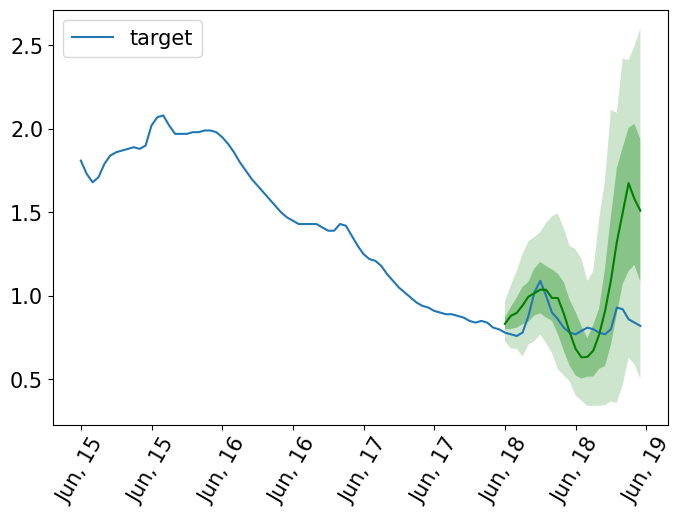

In [ ]:
cl16 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'
cl32 = ckpt_dir + '/cl32_lr10e3/checkpoints/epoch=41-step=2100.ckpt'
cl64 = ckpt_dir + '/cl64_lr10e4*5/checkpoints/epoch=42-step=2150.ckpt'

forecasts, tss = get_lag_llama_predictions(
    test,
    model_ckpt = cl32,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

## No RoPE models

In [ ]:
ckpt_dir = '/content/drive/MyDrive/Python Scripts/Lag Llama experiments/lightning_logs/No RoPE models'

cl128_10e4 = ckpt_dir + '/cl128_lr10e4/checkpoints/epoch=46-step=2350.ckpt'
cl128_10e4_5 = ckpt_dir + '/cl128_lr10e4*5/checkpoints/epoch=33-step=1700.ckpt'
cl256_10e4 = ckpt_dir + '/cl256_lr10e4/checkpoints/epoch=40-step=2050.ckpt'
cl256_10e3 = ckpt_dir + '/cl256_lr10e3/checkpoints/epoch=48-step=2450.ckpt'
cl256_10e4_5 = ckpt_dir + '/cl256_lr10e4*5/checkpoints/epoch=47-step=2400.ckpt'

### Model: cl128_10e4

In [ ]:
# Produce forecasts
df_forecasts_128_10e4 = recursive_forecast(model_ckpt = cl128_10e4, context_df=df_train[-128:], test_df = df_test)

Forecasting batches:   0%|          | 0/128 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/128 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/152 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/152 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/176 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/176 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/200 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/200 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/224 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/224 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/248 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/248 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/272 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/272 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/296 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/296 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/320 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/320 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/344 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/344 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/368 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/368 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/392 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/392 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/416 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/416 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/440 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/464 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/464 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/488 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/488 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/536 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/536 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/560 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/560 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/584 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/584 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/608 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/608 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/632 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/632 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/656 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/656 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/680 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/680 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/704 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/704 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/728 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/728 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/752 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/752 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/776 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/776 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/800 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/800 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/824 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/824 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/848 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/848 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/872 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/872 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/896 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/896 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/920 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/920 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/944 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/944 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/968 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/968 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/992 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/992 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1016 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1016 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1040 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1040 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1064 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1064 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1088 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1088 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1544 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_128_10e4, 'wave_height', 'forecasts')

# Evaluation
metric = mean_absolute_error(df_forecasts_128_10e4['wave_height'], df_forecasts_128_10e4['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.3554498476684093


### Model: cl128_10e4*5


In [ ]:
# Produce forecasts
df_forecasts_128_10e4_5 = recursive_forecast(model_ckpt = cl128_10e4_5, context_df=df_train[-128:], test_df = df_test)

Forecasting batches:   0%|          | 0/128 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/128 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/152 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/152 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/176 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/176 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/200 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/200 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/224 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/224 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/248 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/248 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/272 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/272 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/296 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/296 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/320 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/320 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/344 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/344 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/368 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/368 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/392 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/392 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/416 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/416 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/440 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/464 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/464 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/488 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/488 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/536 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/536 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/560 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/560 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/584 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/584 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/608 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/608 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/632 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/632 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/656 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/656 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/680 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/680 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/704 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/704 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/728 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/728 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/752 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/752 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/776 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/776 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/800 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/800 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/824 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/824 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/848 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/848 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/872 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/872 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/896 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/896 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/920 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/920 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/944 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/944 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/968 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/968 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/992 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/992 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1016 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1016 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1040 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1040 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1064 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1064 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1088 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1088 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1112 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1112 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1136 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1136 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1160 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1160 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1184 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1184 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1208 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1208 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1232 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1232 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1544 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_128_10e4_5, 'wave_height', 'forecasts')

# Evaluation
metric = mean_absolute_error(df_forecasts_128_10e4_5['wave_height'], df_forecasts_128_10e4_5['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.484915523118443


### Model cl256_lr10e3

In [ ]:
# Produce forecasts
df_forecasts_256_10e3 = recursive_forecast(model_ckpt = cl256_10e3, context_df=df_train[-256:], test_df = df_test)

Forecasting batches:   0%|          | 0/256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/544 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/568 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/568 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/592 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/592 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/616 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/616 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/640 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/640 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/664 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/664 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/688 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/688 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/712 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/712 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/736 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/736 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/760 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/760 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/784 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/784 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/808 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/808 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/832 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/832 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/856 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/856 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/880 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/880 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/904 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/904 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/928 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/928 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/952 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/952 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/976 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/976 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1000 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1024 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1048 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1048 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1072 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1072 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1096 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1432 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1456 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1456 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1480 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1480 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1504 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1504 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1528 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1528 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1552 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1552 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1576 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1576 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1600 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1600 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1624 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1624 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1648 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1648 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1672 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1672 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_256_10e3, 'wave_height', 'forecasts')

# Evaluation
metric = mean_absolute_error(df_forecasts_256_10e3['wave_height'], df_forecasts_256_10e3['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.43134109632174167


### Model cl256_lr10e4

In [ ]:
# Produce forecasts
df_forecasts_256_10e4 = recursive_forecast(model_ckpt = cl256_10e4, context_df=df_train[-256:], test_df = df_test)

Forecasting batches:   0%|          | 0/256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/544 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/568 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/568 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/592 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/592 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/616 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/616 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/640 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/640 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/664 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/664 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/688 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/688 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/712 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/712 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/736 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/736 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/760 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/760 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/784 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/784 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/808 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/808 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/832 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/832 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/856 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/856 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/880 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/880 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/904 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/904 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/928 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/928 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/952 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/952 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/976 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/976 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1000 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1024 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1048 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1048 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1072 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1072 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1096 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1432 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1456 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1456 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1480 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1480 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1504 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1504 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1528 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1528 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1552 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1552 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1576 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1576 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1600 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1600 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1624 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1624 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1648 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1648 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1672 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1672 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_256_10e4, 'wave_height', 'forecasts')

# Evaluation
metric = mean_absolute_error(df_forecasts_256_10e4['wave_height'], df_forecasts_256_10e4['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.36377834645575946


### Model cl256_lr10e4*5

In [ ]:
# Produce forecasts
df_forecasts_256_10e4_5 = recursive_forecast(model_ckpt = cl256_10e4_5, context_df=df_train[-256:], test_df = df_test)

Forecasting batches:   0%|          | 0/256 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/256 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/280 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/280 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/304 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/304 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/328 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/328 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/352 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/352 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/376 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/376 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/400 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/400 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/424 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/424 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/448 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/448 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/472 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/472 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/496 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/496 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/520 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/520 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/544 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/544 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/568 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/568 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/592 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/592 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/616 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/616 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/640 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/640 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/664 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/664 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/688 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/688 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/712 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/712 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/736 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/736 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/760 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/760 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/784 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/784 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/808 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/808 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/832 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/832 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/856 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/856 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/880 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/880 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/904 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/904 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/928 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/928 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/952 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/952 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/976 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/976 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1000 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1024 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1024 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1048 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1048 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1072 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1072 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1096 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1096 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1120 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1120 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1144 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1144 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1168 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1168 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1192 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1192 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1216 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1216 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1240 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1240 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1264 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1288 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1288 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1312 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1312 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1336 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1336 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1360 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1360 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1384 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1384 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1408 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1408 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1432 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1432 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1456 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1456 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1480 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1480 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1504 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1504 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1528 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1528 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1552 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1552 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1576 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1576 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1600 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1600 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1624 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1624 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1648 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1648 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1672 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1672 [00:00<?, ?it/s]

In [ ]:
# Plot
plot_backtest_preds(df_forecasts_256_10e4_5, 'wave_height', 'forecasts')

# Evaluation
metric = mean_absolute_error(df_forecasts_256_10e4_5['wave_height'], df_forecasts_256_10e4_5['forecasts'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.6111627377569675


## Other performance metrics

In [ ]:
evaluator = Evaluator()

In [ ]:
forecasts, tss = get_lag_llama_predictions(
    test,
    model_ckpt = cl128_10e4,
    prediction_length=24,
    num_samples=100,
    device='cuda'
)

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

In [ ]:
agg_metrics, _ = evaluator(iter(tss), iter(forecasts), num_series=len(test))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 51.70it/s]


In [ ]:
agg_metrics

{'MSE': 0.018334727734327316,
 'abs_error': 2.228173017501831,
 'abs_target_sum': 20.31999969482422,
 'abs_target_mean': 0.8466666539510092,
 'seasonal_error': 0.32948996006757364,
 'MASE': 0.28177047451421394,
 'MAPE': 0.10741480191548665,
 'sMAPE': 0.10629305243492126,
 'MSIS': 2.473340220442498,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 0.8101182103157044,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.2]': 1.0205741643905641,
 'Coverage[0.2]': 0.041666666666666664,
 'QuantileLoss[0.3]': 1.2692823648452758,
 'Coverage[0.3]': 0.4166666666666667,
 'QuantileLoss[0.4]': 1.8504046916961672,
 'Coverage[0.4]': 0.625,
 'QuantileLoss[0.5]': 2.228173077106476,
 'Coverage[0.5]': 0.7083333333333334,
 'QuantileLoss[0.6]': 2.4948385238647464,
 'Coverage[0.6]': 0.8333333333333334,
 'QuantileLoss[0.7]': 2.623659455776215,
 'Coverage[0.7]': 0.8333333333333334,
 'QuantileLoss[0.8]': 2.561959362030029,
 'Coverage[0.8]': 0.8333333333333334,
 'QuantileLoss[0.9]': 1.756862127780914,
 'Coverage[0.9

# Forecasting with fine-tuned models - Daily data

In [68]:
ckpt_dir = '/content/drive/MyDrive/Python Scripts/Lag Llama experiments/lightning_logs/Weekly - No RoPE'

version_2 = ckpt_dir + '/version_2/checkpoints/epoch=0-step=50.ckpt'
version_6 = ckpt_dir + '/version_6/checkpoints/epoch=0-step=50.ckpt'

### Version 2

In [81]:
# Produce forecasts
forecasts_v2 = recursive_forecast(model_ckpt = version_2, context_df=df_train[-48:], test_df = df_test)
df_forecasts_v2 = df_test.copy()
df_forecasts_v2['prediction'] = forecasts_v2['prediction']
df_forecasts_v2['p10'] = forecasts_v2['p10']
df_forecasts_v2['p90'] = forecasts_v2['p90']

Forecasting batches:   0%|          | 0/48 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/48 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/55 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/55 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/62 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/62 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/69 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/69 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/76 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/76 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/83 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/83 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/90 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/90 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/97 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/97 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/111 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/111 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/118 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/118 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/125 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/125 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/132 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/132 [00:00<?, ?it/s]

In [80]:
plot_prob_forecasts(df_forecasts_v2)

In [84]:
# Point forecast metric - MAE
# ==============================================================================
metric = mean_absolute_error(df_forecasts_v2['wave_height'], df_forecasts_v2['prediction'])
print(f"Backtest error (MAE): {metric}")

# Predicted interval coverage
# ==============================================================================
coverage = empirical_coverage(
    y = df_forecasts_v2['wave_height'],
    lower_bound = df_forecasts_v2['p10'],
    upper_bound = df_forecasts_v2['p90']
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (df_forecasts_v2['p90'] - df_forecasts_v2['p10']).sum()
print(f"Area of the interval: {round(area, 2)}")

Backtest error (MAE): 0.6623311723073324
Predicted interval coverage: 63.33 %
Area of the interval: 148.0500030517578


### Version 6

In [82]:
# Produce forecasts
forecasts_v6 = recursive_forecast(model_ckpt = version_6, context_df=df_train[-48:], test_df = df_test)
df_forecasts_v6 = df_test.copy()
df_forecasts_v6['prediction'] = forecasts_v6['prediction']
df_forecasts_v6['p10'] = forecasts_v6['p10']
df_forecasts_v6['p90'] = forecasts_v6['p90']

Forecasting batches:   0%|          | 0/48 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/48 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/55 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/55 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/62 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/62 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/69 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/69 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/76 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/76 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/83 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/83 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/90 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/90 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/97 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/97 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/104 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/104 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/111 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/111 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/118 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/118 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/125 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/125 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/132 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/132 [00:00<?, ?it/s]

In [83]:
plot_prob_forecasts(df_forecasts_v6)

In [85]:
# Point forecast metric - MAE
# ==============================================================================
metric = mean_absolute_error(df_forecasts_v6['wave_height'], df_forecasts_v6['prediction'])
print(f"Backtest error (MAE): {metric}")

# Predicted interval coverage
# ==============================================================================
coverage = empirical_coverage(
    y = df_forecasts_v6['wave_height'],
    lower_bound = df_forecasts_v6['p10'],
    upper_bound = df_forecasts_v6['p90']
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (df_forecasts_v6['p90'] - df_forecasts_v6['p10']).sum()
print(f"Area of the interval: {round(area, 2)}")

Backtest error (MAE): 0.6861148397127788
Predicted interval coverage: 67.78 %
Area of the interval: 147.5500030517578
